# Initial test of data plotting
- Early stage build of a project. 
- This is a test at pulling images from a h5 file and displaying them.
- Future projects will use a modified version of this code. 

The data used is from Oak Ridge National Labratory<br>
**Big Data Analytics for Scanning Transmission Electron Microscopy Ptychography**

# Using this program

Simply run this program. It will download the datafile. 

# Initilaization

The code will import the required packages as well as allow for the import of the data.

In [19]:
# System check
import sys
!conda install --yes --prefix {sys.prefix} numpy scipy matplotlib scikit-learn Ipython ipywidgets h5py
!{sys.executable} -m pip install -U --no-deps pyUSID==0.0.6.3
!{sys.executable} -m pip install -U --no-deps pycroscopy==0.60.3
!{sys.executable} -m pip install -U --no-deps gdown==3.8.3

Solving environment: ...working... done

# All requested packages already installed.

Requirement already up-to-date: pyUSID==0.0.6.3 in c:\users\booge\anaconda3\lib\site-packages (0.0.6.3)
  Using cached https://files.pythonhosted.org/packages/c7/7a/1d494707ecccb7f336a384fc520a0b25ae95effd6c8dd98ce82ea62ed25c/pycroscopy-0.60.3-py2.py3-none-any.whl
  Found existing installation: pycroscopy 0.60.1
    Uninstalling pycroscopy-0.60.1:
      Successfully uninstalled pycroscopy-0.60.1
Requirement already up-to-date: gdown==3.8.3 in c:\users\booge\anaconda3\lib\site-packages (3.8.3)


In [2]:
# Import Libraries
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, HTML
import ipywidgets as widgets
from sklearn.cluster import KMeans

sys.path.append('..')
import pyUSID as usid
import pycroscopy as px

# Make Notebook take up most of page width
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# set up notebook to show plots within the notebook
%matplotlib notebook

# Load the dataset

This will create a popup window for the user to select and load in the h5 file. 

In [3]:
# Accessing the data file stored on google drive
import gdown
url = 'https://drive.google.com/a/lehigh.edu/uc?id=1u1V8IiiGrZuyG7nF5ot1a7OnRiIlDbaA'
output = '4D.h5'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/a/lehigh.edu/uc?id=1u1V8IiiGrZuyG7nF5ot1a7OnRiIlDbaA
To: C:\Users\booge\Documents\4D.h5
217MB [00:08, 25.9MB/s] 


'4D.h5'

In [4]:
data_file_path = '4D.h5'
h5_file = h5py.File(data_file_path, mode='r+')

# Raw Data

This section does the following three things
- Selects the dataset containing the raw data
- Converts the data from a HDF5 sataset to a USIDataset
- Reads the parameters

In [5]:
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Mean_Ronchigram
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-Decomposition_000
      --------------------------
      ├ Components
      ├ Position_Indices
      ├ Position_Values
      ├ Projection
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Raw_Data-SVD_000
      ----------------
      ├ Position_Indices
      ├ Position_Values
      ├ S
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ U
      ├ U-Cluster_000
        -------------
        ├ Cluster_Indices
        ├ Cluster_Values
        ├ Labels
        ├ Mean_Resp_Pos_Indices
        ├ Mean_Resp_Pos_Values
        ├ Mean_Response
        ├ Spectroscopic_Indices
        ├ Spectroscopic_Values
      ├ V
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Mean
    ├ Spectroscopic_Values


In [6]:
# Select the dataset containing the raw data to start working with:
h5_main = usid.hdf_utils.find_dataset(h5_file, 'Raw_Data')[-1]

# Upgrade this object from a regular HDF5 dataset to a USIDataset:
h5_main = usid.USIDataset(h5_main)

# Read some necessary parameters:
h5_pos_inds = h5_main.h5_pos_inds
num_rows, num_cols = h5_main.pos_dim_sizes
h5_spec_inds = h5_main.h5_spec_inds
num_sensor_rows, num_sensor_cols = h5_main.spec_dim_sizes

C:\Users\booge\Anaconda3\lib\site-packages\pyUSID\io\hdf_utils.py:722: UserWarning: units attribute was missing
  warn('units attribute was missing')


# Raw Ronchigrams

The raw ronchigrams are plotted in this section.

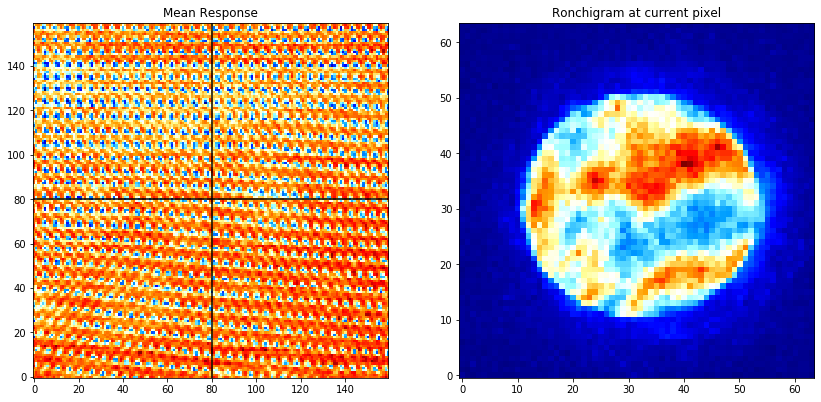

In [7]:
coarse_row = int(0.5*num_rows)
coarse_col = int(0.5*num_cols)
coarse_pos = coarse_row * num_rows + coarse_col

current_ronch = np.reshape(h5_main[coarse_pos], (num_sensor_rows, num_sensor_cols))

fig, axes = plt.subplots(ncols=2, figsize=(14,7))
#axes[0].hold(True)
axes[0].set_title('Mean Response')
main_map = axes[0].imshow(np.reshape(h5_main.parent['Spectroscopic_Mean'], (num_rows, num_cols)), 
                          cmap=px.plot_utils.cmap_jet_white_center(), origin='lower')
main_vert_line = axes[0].axvline(x=coarse_col, color='k')
main_hor_line = axes[0].axhline(y=coarse_row, color='k')
axes[1].set_title('Ronchigram at current pixel')
img_zoom = axes[1].imshow(current_ronch,cmap=px.plot_utils.cmap_jet_white_center(), origin='lower')

def move_zoom_box(event):
    if not main_map.axes.in_axes(event):
        return
    
    coarse_col = int(round(event.xdata))
    coarse_row = int(round(event.ydata))
    main_vert_line.set_xdata(coarse_col)
    main_hor_line.set_ydata(coarse_row)
    
    coarse_pos = coarse_row * num_rows + coarse_col
    current_ronch = np.reshape(h5_main[coarse_pos], (num_sensor_rows, num_sensor_cols))

    img_zoom.set_data(current_ronch)
    #img_zoom.set_clim(vmax=ronch_max, vmin=ronch_min)
    fig.canvas.draw()
    

cid = main_map.figure.canvas.mpl_connect('button_press_event', move_zoom_box)
# widgets.interact(move_zoom_box, coarse_row=(0, num_rows, 1), 
#                  coarse_col=(0, num_cols, 1));

# Single Value Decomposition

Here we perform some basic linear algebra to get the eigenvectors and eigenvalues. 

In [8]:
# Choose how many components you want
num_svd_comps = 256

proc = px.processing.SVD(h5_main, num_components=num_svd_comps)

h5_svd_group = proc.compute()
    
h5_u = h5_svd_group['U']
h5_v = h5_svd_group['V']
h5_s = h5_svd_group['S']

C:\Users\booge\Anaconda3\lib\site-packages\pycroscopy\core\io\hdf_utils.py:722: UserWarning: units attribute was missing
  warn('units attribute was missing')


Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: SVD has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SVD_000" (8 members)>]
Returning previously computed results from: /Measurement_000/Channel_000/Raw_Data-SVD_000
set the "override" flag to True to recompute results


# SVD Visualization

The varience, eigenvalues, and eigenvectors are visaulized. 
- S is the varience
- U is the eigenvalues
- V is the eigenvectors 

In [9]:
# Choose how many components of U and V to display
num_plot_comps = 16

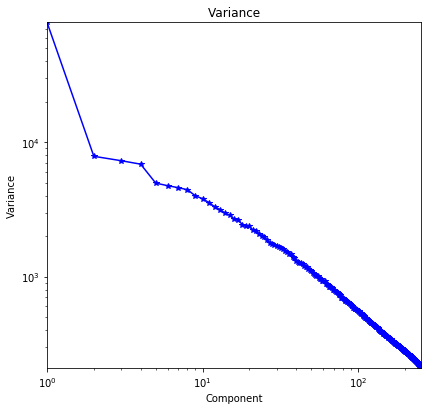

In [10]:
# Visualize variance of the principal components
fig, axes = usid.plot_utils.plot_scree(h5_s, title='Variance')

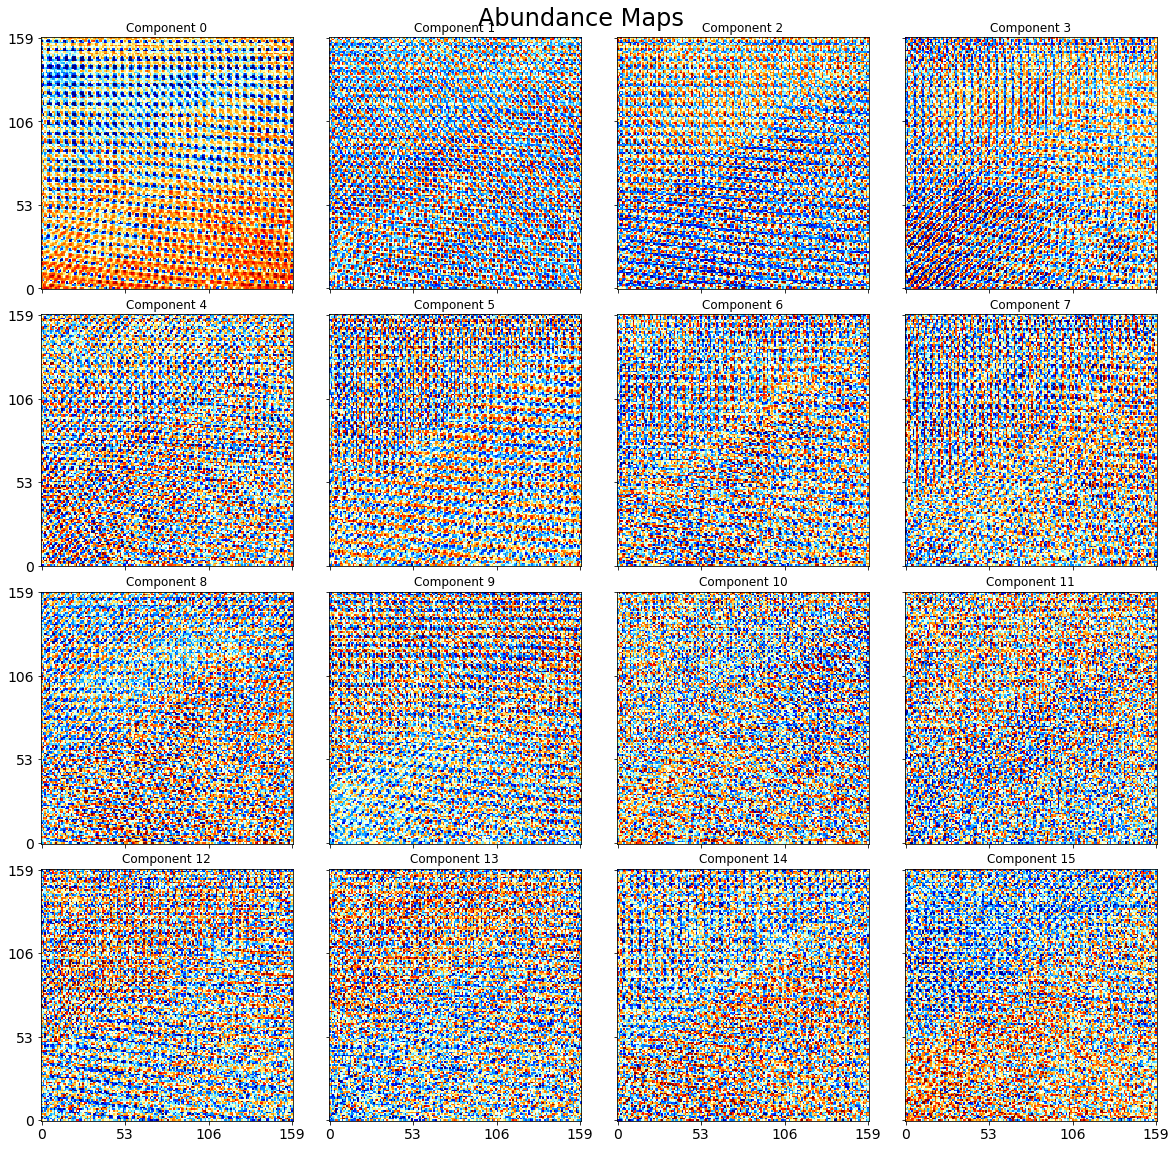

In [11]:
# Visualize the abundance maps from SVD:
loadings = np.reshape(h5_u[:, :num_plot_comps], (num_rows, num_cols, -1)).transpose([2, 0, 1])
fig, axes = usid.plot_utils.plot_map_stack(loadings, num_comps=num_plot_comps, title='Abundance Maps',
                                         cmap=px.plot_utils.cmap_jet_white_center())

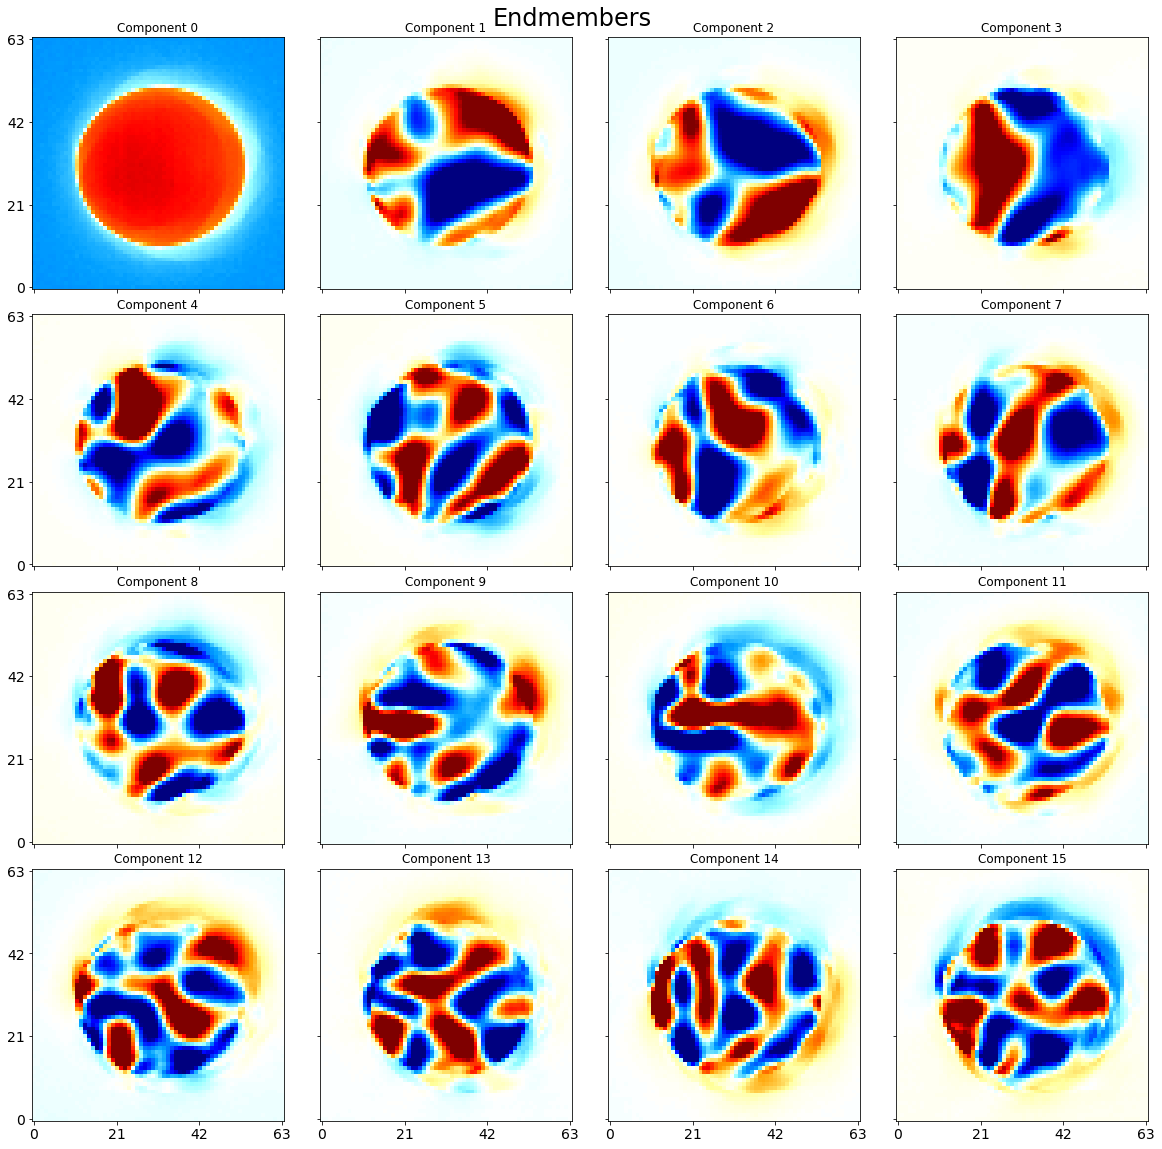

In [12]:
# Visualize the Endmembers from SVD:
eigenvectors = np.reshape(h5_v[:num_plot_comps], (-1, num_sensor_rows, num_sensor_cols))
fig, axes = usid.plot_utils.plot_map_stack(eigenvectors, num_comps=num_plot_comps, title='Endmembers',
                                         cmap=px.plot_utils.cmap_jet_white_center())

# Clustering

Here, the varience is lmited and the data is clustered according to the varience. 

In [13]:
# Choose how many SVD components to use in clustering
spectral_components = 128
# Choose how many clusters to use
num_clusters = 32

In [14]:
estimator = KMeans(n_clusters=num_clusters)

proc = px.processing.Cluster(h5_u, estimator, num_comps=spectral_components)

h5_kmeans_group = proc.compute()
    
h5_labels = h5_kmeans_group['Labels']
h5_centroids = h5_kmeans_group['Mean_Response']

# In case we take existing results, we need to get these parameters
num_comps_for_clustering = h5_centroids.shape[1]

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Performing clustering on /Measurement_000/Channel_000/Raw_Data-SVD_000/U.
Took 1.29 mins to compute KMeans
Calculated the Mean Response of each cluster.
Starting computing on 1 cores (requested 1 cores)
Computing serially ...
Took 2.39 sec to calculate mean response per cluster
Writing clustering results to file.


C:\Users\booge\Anaconda3\lib\site-packages\pycroscopy\core\io\hdf_utils.py:722: UserWarning: units attribute was missing
  warn('units attribute was missing')


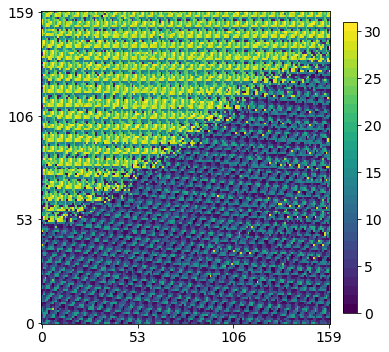

In [15]:
label_mat = np.reshape(h5_labels, (num_rows, num_cols))
fig, axes = px.viz.cluster_utils.plot_cluster_labels(label_mat, num_clusters=num_clusters)

Creating full dendrogram from clusters


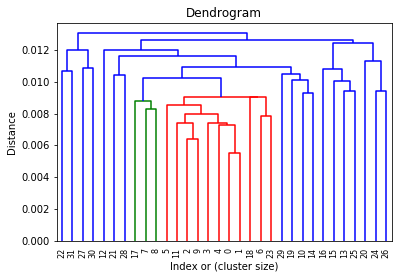

In [16]:
e_vals = np.reshape(h5_u[:, :spectral_components], 
                    (num_rows, num_cols, -1))
fig = px.viz.cluster_utils.plot_cluster_dendrogram(label_mat, e_vals, 
                                                   num_comps_for_clustering, 
                                                   num_clusters, 
                                                   last=num_clusters);

# Close and Save

In [17]:
h5_file.close()